In [1]:
import pandas as pd
import csv
import numpy as np

df = pd.read_csv("Dataset(SMOTE).csv", low_memory=False)
df

,label,file_access,pe_imports,sig_clamav,pe_sec_character,sig_antivirus_virustotal,cmd_exec,api_resolv,pe_sec_entropy,pe_sec_name,...,sig_antianalysis_detectfile,sig_network_cnc_http,sig_removes_zoneid_ads,sig_downloader_cabby,sig_sniffer_winpcap,sig_creates_largekey,sig_infostealer_bitcoin,sig_static_detection,sig_antiav_servicestop,sig_recon_beacon
0,0,764,129,560,81,2280,102,1302,1147,211,...,2,12,5,2,2,3,0,231,4,11
1,0,984,129,560,81,2018,112,1302,1147,211,...,2,12,5,2,2,3,0,231,4,11
2,0,2164,1394,560,77,2018,541,237,124,207,...,2,12,5,2,2,3,0,231,4,11
3,0,946,962,560,81,2214,527,1212,183,211,...,2,12,5,2,2,3,0,231,4,11
4,0,1743,1345,560,77,216,144,634,73,207,...,2,12,5,2,2,3,0,231,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,4,666,561,560,106,852,541,634,2102,232,...,2,12,5,2,2,3,0,230,4,11
10096,4,1099,427,560,107,2018,541,634,309,233,...,2,12,5,2,2,3,0,231,4,11
10097,4,1856,1407,560,81,1573,541,639,1626,211,...,2,12,5,2,2,3,0,71,4,11
10098,4,1846,1373,560,102,331,541,634,1354,230,...,2,12,5,2,2,3,0,118,4,11


In [2]:
from sklearn.model_selection import train_test_split

# Separating the features from the target variable
X = df.iloc[:, 1:65]
y = df['label']

# Splitting the data into a train and a dev set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0) 

In [3]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

rfc = RandomForestClassifier(criterion='gini',max_depth=12, max_features='sqrt',
                             min_samples_split=10, n_estimators=200, random_state=0)

boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=0)

boruta_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	29
Tentative: 	5
Rejected: 	30
Iteration: 	9 / 100
Confirmed: 	29
Tentative: 	5
Rejected: 	30
Iteration: 	10 / 100
Confirmed: 	29
Tentative: 	5
Rejected: 	30
Iteration: 	11 / 100
Confirmed: 	29
Tentative: 	5
Rejected: 	30
Iteration: 	12 / 100
Confirmed: 	30
Tentative: 	4
Rejected: 	30
Iteration: 	13 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	32
Iteration: 	14 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	32
Iteration: 	15 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	32
Iteration: 	16 / 100
Confirmed: 	31
Tentative: 	1
Reject

BorutaPy(estimator=RandomForestClassifier(max_depth=12, min_samples_split=10,
                                          n_estimators=66,
                                          random_state=RandomState(MT19937) at 0x1C1B8091340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1C1B8091340, verbose=2)

In [5]:
# Using the BorutaPy object to transform the features in the dataset.
X_important_train = boruta_selector.transform(np.array(X_train))
X_important_test = boruta_selector.transform(np.array(X_test)) 

In [7]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

lgb_boruta = lgb.LGBMClassifier(random_state=0)

# Define search space
param_grid = { 
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'bagging_fraction': [0.5, 0.75, 0.9],
    'feature_fraction': [0.1, 0.5, 0.9]
}

# Create GridSearchCV object
grid_lgb = GridSearchCV(lgb_boruta, param_grid, refit=True, n_jobs=-1, cv=10, verbose=3, scoring='accuracy')

# Fit the data
grid_lgb.fit(X_important_train, y_train)

# Print best parameters and accuracy score
print("Best parameters found: ", grid_lgb.best_params_)
print("Best accuracy score found: {:.4f}".format(grid_lgb.best_score_))

Fitting 10 folds for each of 486 candidates, totalling 4860 fits
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
Best parameters found:  {'bagging_fraction': 0.5, 'boosting_type': 'dart', 'feature_fraction': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 30}
Best accuracy score found: 0.8944


In [8]:
#  Give best model as a result
lgb_model = grid_lgb.best_estimator_
lgb_model

LGBMClassifier(bagging_fraction=0.5, boosting_type='dart', feature_fraction=0.5,
               max_depth=7, num_leaves=30, random_state=0)

In [9]:
import lightgbm as lgb

# Instantiate model
lgb_model = lgb.LGBMClassifier(bagging_fraction=0.5, boosting_type='dart', feature_fraction=0.5,
                               learning_rate=0.1, max_depth=7, num_leaves=30, random_state=0)

# Train the model on training data
lgb_model.fit(X_important_train, y_train)

# Use the forest's predict method on the test data
lgb_predict = lgb_model.predict(X_important_test)

In [10]:
from sklearn import metrics

# Accuracy
print(metrics.accuracy_score(y_test, lgb_predict))
# Precision
print(metrics.precision_score(y_test, lgb_predict, average='macro'))
# Recall
print(metrics.recall_score(y_test, lgb_predict, average='macro'))
# F1 Score
print(metrics.f1_score(y_test, lgb_predict, average='macro'))

0.904950495049505
0.9128499058388467
0.9029256025343241
0.9002089514882954


C:\Users\user\AppData\Local\Temp\ipykernel_2704\2779119820.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
C:\Users\user\AppData\Local\Temp\ipykernel_2704\2779119820.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(b)


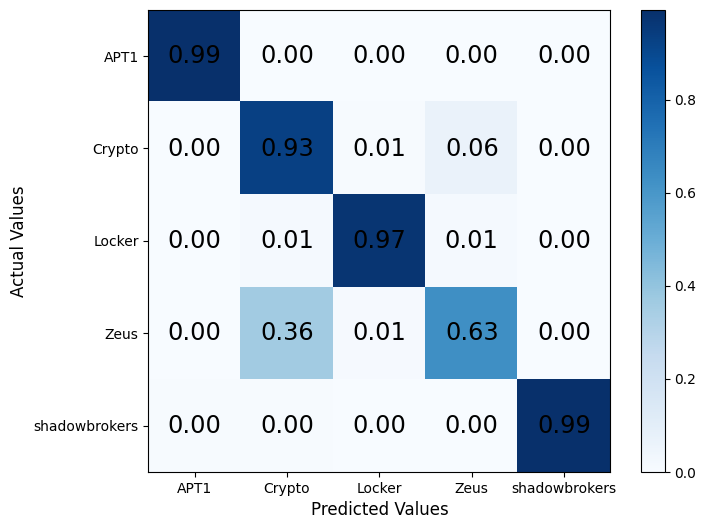

In [11]:
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, lgb_predict, normalize = 'true')

fig, ax = plt.subplots(figsize=(8, 6))
caxes = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(caxes)
fmt = '.2f'
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=format(conf_matrix[i, j], fmt), va='center', ha='center', size='xx-large')

a=ax.get_xticks().tolist()
a[1]='APT1'
a[2]='Crypto'
a[3]='Locker'
a[4]='Zeus'
a[5]='shadowbrokers'

b=ax.get_yticks().tolist()
b[1]='APT1'
b[2]='Crypto'
b[3]='Locker'
b[4]='Zeus'
b[5]='shadowbrokers'
ax.set_xticklabels(a)
ax.set_yticklabels(b)

plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Actual Values', fontsize=12)
plt.gca().xaxis.tick_bottom()
plt.show()

In [12]:
lgb2_boruta = lgb.LGBMClassifier(random_state=0)

# Define search space
param_grid = { 
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'bagging_fraction': [0.5, 0.75, 0.9],
    'feature_fraction': [0.1, 0.5, 0.9]
}

# Create GridSearchCV object
grid_lgb2 = GridSearchCV(lgb2_boruta, param_grid, refit=True, n_jobs=-1, cv=10, verbose=3, scoring='accuracy')

# Fit the data
grid_lgb2.fit(X_train, y_train)

# Print best parameters and accuracy score
print("Best parameters found: ", grid_lgb2.best_params_)
print("Best accuracy score found: {:.4f}".format(grid_lgb2.best_score_))

Fitting 10 folds for each of 486 candidates, totalling 4860 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
Best parameters found:  {'bagging_fraction': 0.5, 'boosting_type': 'dart', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 30}
Best accuracy score found: 0.8948


In [3]:
import lightgbm as lgb

# Instantiate model
lgb2_model = lgb.LGBMClassifier(bagging_fraction=0.5, boosting_type='dart', feature_fraction=0.9,
                               learning_rate=0.1, max_depth=7, num_leaves=30, random_state=0)

# Train the model on training data
lgb2_model.fit(X_train, y_train)

# Use the forest's predict method on the test data
lgb2_predict = lgb2_model.predict(X_test)

# Export the predicted values
np.savetxt("LightGBM_Imbalanced(80-20).csv", lgb2_predict, delimiter=",")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


In [14]:
from sklearn import metrics

# Accuracy
print(metrics.accuracy_score(y_test, lgb2_predict))
# Precision
print(metrics.precision_score(y_test, lgb2_predict, average='macro'))
# Recall
print(metrics.recall_score(y_test, lgb2_predict, average='macro'))
# F1 Score
print(metrics.f1_score(y_test, lgb2_predict, average='macro'))

0.905940594059406
0.9158203434632757
0.904111860571574
0.9012668049522532


C:\Users\user\AppData\Local\Temp\ipykernel_2704\2464941857.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
C:\Users\user\AppData\Local\Temp\ipykernel_2704\2464941857.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(b)


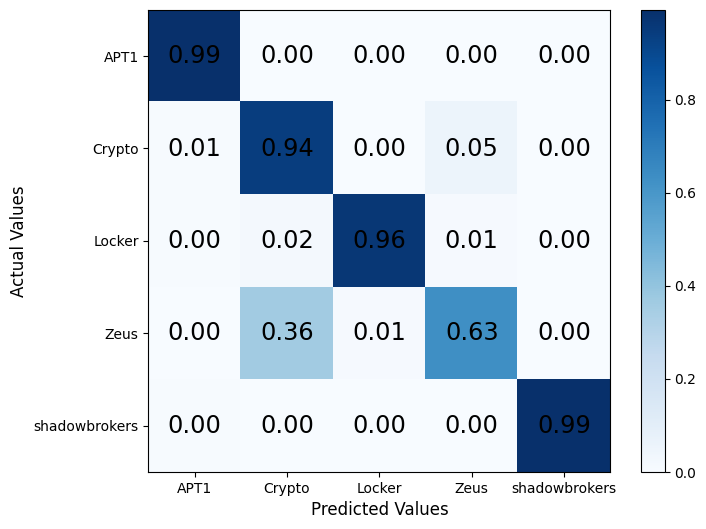

In [15]:
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, lgb2_predict, normalize = 'true')

fig, ax = plt.subplots(figsize=(8, 6))
caxes = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(caxes)
fmt = '.2f'
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=format(conf_matrix[i, j], fmt), va='center', ha='center', size='xx-large')

a=ax.get_xticks().tolist()
a[1]='APT1'
a[2]='Crypto'
a[3]='Locker'
a[4]='Zeus'
a[5]='shadowbrokers'

b=ax.get_yticks().tolist()
b[1]='APT1'
b[2]='Crypto'
b[3]='Locker'
b[4]='Zeus'
b[5]='shadowbrokers'
ax.set_xticklabels(a)
ax.set_yticklabels(b)

plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Actual Values', fontsize=12)
plt.gca().xaxis.tick_bottom()
plt.show()